In [1]:
###########################################################################
# This notebook is authored by: Ayan Paul                                 #
# Date: January 2021                                                      #
# If you use this code or the results from this work please cite:         # 
# Emergence of universality in the transmission dynamics of COVID-19      #
# Ayan Paul, Jayanta Kumar Bhattacharjee, Aksay Pal and Sagar Chakraborty #
# arXiv:2011.13945 (https://arxiv.org/abs/2011.13945)                     # 
###########################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.signal import argrelextrema
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import math
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#121212'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
rc('font',**{'family':'serif','serif':['New Century Schoolbook']})

window_size = 7

In [2]:
# Load the fit data from UniversalityClasses-DNN.ipynb and UniversalityClasses-BSM.ipynb
data = np.loadtxt('data/type1-DNN.txt')
spline_t1a = interpolate.splrep(data[0], data[1])
t_fact_1a = data[0][argrelextrema(data[2], np.greater)[0]][0]

data = np.loadtxt('data/type1-BSM.txt')
spline_t1b = interpolate.splrep(data[0], data[1])
t_fact_1b = data[0][argrelextrema(data[2], np.greater)[0]][0]

data = np.loadtxt('data/type2-DNN.txt')
spline_t2a = interpolate.splrep(data[0], data[1])
t_fact_2a = data[0][argrelextrema(data[2], np.greater)[0]][0]

data = np.loadtxt('data/type2-BSM.txt')
spline_t2b = interpolate.splrep(data[0], data[1])
t_fact_2b = data[0][argrelextrema(data[2], np.greater)[0]][0]

In [3]:
# Pull in the data processed in DataScout-UniversalityClasses.ipynb
countries = pd.read_csv('data/countries.csv')

In [4]:
def wgaussian(x, mu, sigma, a, c):
    return a/math.sqrt(2.*math.pi)/sigma * np.exp(-0.5*(x-mu)**2 / sigma**2) + c

def makePredictions(country, start_date, fit_date, guess, splines, countries, shift=0):

    # Get the country
    df_stg2 = countries[countries['Country/Region'] == country].iloc[0][4:].rolling(window_size).mean().dropna()
    df_stg2.index = pd.to_datetime(df_stg2.index)

    # The number of cases at the end of the first wave
    N_1w = df_stg2[start_date]

    # Setting the counter to 0 at the beginning of the first wave
    df_stg2 = df_stg2[start_date:]-df_stg2[start_date]

    # Get the number of daily cases
    df_stg2_diff = df_stg2.diff().dropna()

    # Compute the half-life from the peak of the distribution
    df = pd.DataFrame()
    df['Y'] = df_stg2_diff[:fit_date].values
    df['X'] = range(0, len(df))
    x_g = df['X'].values
    y_g = df['Y'].values
    fit, covar = curve_fit(wgaussian, x_g, y_g, p0=guess)
    perr = np.sqrt(np.diag(covar))
    
    # Plot the predicitions
    plt.figure(figsize=(7.5,6))
    plt.plot(df_stg2[:datetime.date.today().strftime('%Y-%m-%d')]+N_1w, label='from '+start_date+' to '+datetime.date.today().strftime('%Y-%m-%d'), linewidth=3, color='#4b659a', zorder=100)
    plt.plot(df_stg2[datetime.date.today().strftime('%Y-%m-%d'):'2020-12-31']+N_1w, label='predictions:', linestyle=':', color='#ffffff', linewidth=3, zorder=100)
    
    # Get the variation in tau
    # Compute a prediction for the second wave for tau = 2.5
    # get the date for the prediction
    colors = ['#434343', '#71c5e7', '#434343', '#71c5e7']
    labels = ['Type I - DNN', 'Type I - BSM', 'Type II - DNN', 'Type II - BSM']
#     labels = ['Type II - DNN', 'Type II - BSM']
    types = ['dashed', 'dashed', 'dashdot', 'dashdot']
    facts = [1./t_fact_1a, 1./t_fact_1b, 1./t_fact_2a, 1./t_fact_2b]
#     facts = [1./t_fact_1a, 1./t_fact_1b]
    alphas1 = [0.6, 1, 0.6, 1]
    alphas2 = [0.1, 0.2, 0.1, 0.2]
    N_r_d = []
    t2w = []
    for i in range(len(splines)):
        t_1_2 = int(round(fit[0]*facts[i] + shift))
        t_1_2_u = int(round((fit[0] + 2.*perr[0])*facts[i] + shift))
        t_1_2_l = int(round((fit[0] - 2.*perr[0])*facts[i] + shift))
        Nmax = df_stg2[df_stg2.idxmin() + datetime.timedelta(t_1_2)]*2
        Nmax_u = df_stg2[df_stg2.idxmin() + datetime.timedelta(t_1_2_u)]*2
        Nmax_l = df_stg2[df_stg2.idxmin() + datetime.timedelta(t_1_2_l)]*2
        
        d_range = np.linspace(0, int(2.5*t_1_2), t_1_2+1)
        t_2w = [df_stg2.idxmin() + datetime.timedelta(i) for i in d_range]
        predict = interpolate.splev(d_range/t_1_2, splines[i], der=0)
        predict_l = interpolate.splev(d_range/t_1_2_l, splines[i], der=0)
        predict_u = interpolate.splev(d_range/t_1_2_u, splines[i], der=0)
        N_r = (Nmax*predict + N_1w)
        N_r_d.append(np.diff(N_r)/2.5)
        N_r_l = (Nmax_l*predict_l + N_1w)
        N_r_d.append(np.diff(N_r_l)/2.5)
        N_r_u = (Nmax_u*predict_u + N_1w)
        N_r_d.append(np.diff(N_r_u)/2.5)
        t2w.append(t_2w[1:])
        plt.plot(t_2w, N_r, label=labels[i]+r'  [$t_{1/2}$: '+str(t_1_2) + ' days]', color=colors[i], linewidth=2, linestyle=types[i], alpha=alphas1[i])
        plt.fill_between(t_2w, N_r_l, N_r_u, color=colors[i], alpha=alphas2[i])

    legend = plt.legend(fontsize=11, loc='upper left', title=country)
    plt.setp(legend.get_title(),fontsize=14)
    ax=plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(28))
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right")
    plt.ylabel(r'$N(t)$', fontsize=15)
    plt.ylabel(r'Number of Confirmed Cases', fontsize=15)
    plt.grid()
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.title('Prediction for second wave in '+country, fontsize=18)
    
    
    axins = inset_axes(ax, width=2.5, height=6/7.5*2.5, borderpad=0.3, loc='lower right',bbox_to_anchor=(.11, .10, .875, .15),
                       bbox_transform=ax.transAxes)
    for i in range(len(t2w)):
        plt.plot(t2w[i], N_r_d[3*i], color=colors[i], linewidth=1, linestyle=types[i], alpha=alphas1[i])
        plt.fill_between(t2w[i], N_r_d[3*i+1], N_r_d[3*i+2], color=colors[i], alpha=alphas2[i])
    plt.plot(df_stg2[:datetime.date.today().strftime('%Y-%m-%d')].diff().dropna(), linewidth=3, color='#4b659a')
    plt.plot(df_stg2[datetime.date.today().strftime('%Y-%m-%d'):'2020-12-31'].diff().dropna(), linestyle=':', color='#c0142f', linewidth=3)
    plt.ylabel(r'Daily Cases', fontsize=12)
    
    axins.xaxis.set_major_locator(ticker.MultipleLocator(28))
    plt.setp(axins.get_xticklabels(), rotation=25, ha="right")
    plt.grid()
    
    plt.tight_layout()
    return plt

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


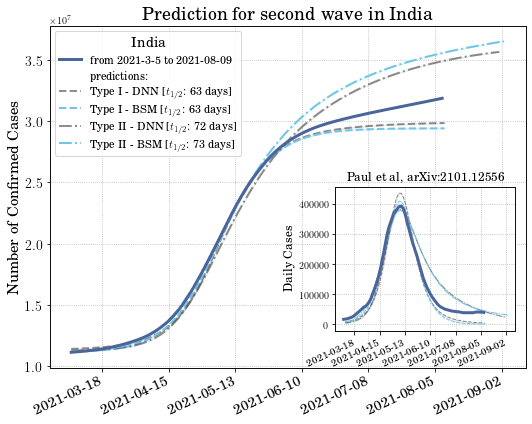

In [8]:
country = 'India'
start_date = '2021-3-5'
spline = [spline_t1a, spline_t1b, spline_t2a, spline_t2b]
fit_date = '2021-6-5'
guess = [75., 10, 3000, 2000]
plt = makePredictions(country, start_date, fit_date, guess, spline, countries)
plt.savefig('../plots/India_prediction.pdf', facecolor='white', dpi=300)
plt.title('Paul et al, arXiv:2101.12556')
plt.show()

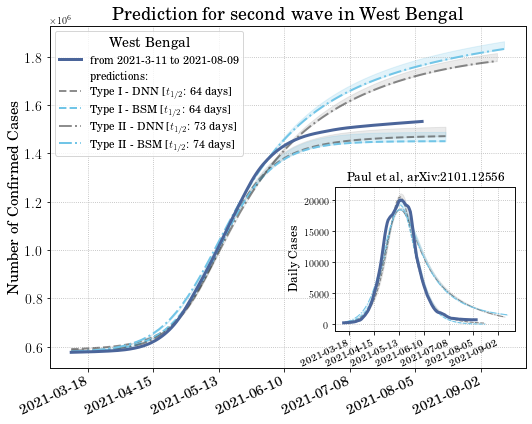

In [9]:
country = 'West Bengal'
start_date = '2021-3-11'
spline = [spline_t1a, spline_t1b, spline_t2a, spline_t2b]
fit_date = '2021-6-6'
guess = [75., 10, 3000, 2000]
plt = makePredictions(country, start_date, fit_date, guess, spline, countries)
plt.savefig('../plots/India_WB_prediction.pdf', facecolor='white', dpi=300)
plt.title('Paul et al, arXiv:2101.12556')
plt.show()

In [5]:
india_states = pd.read_csv('data/India_states.csv')
india_states = india_states.drop('FIPS', axis=1).rename(columns={"admin1": "Country/Region"})

df_covid19_India_1 = india_states.iloc[:,0:5]
df_covid19_India_2 = india_states.iloc[:,5:].cumsum(axis=1)
df_covid19_India = pd.concat([df_covid19_India_1, df_covid19_India_2], axis=1)
countries = df_covid19_India
countries.at[0,'Country/Region'] = 'India'

In [6]:
countries.at[0,'Country/Region'] = 'India'

In [7]:
countries

,country,Country/Region,admin2,population,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,...,2021-07-30 00:00:00,2021-07-31 00:00:00,2021-08-01 00:00:00,2021-08-02 00:00:00,2021-08-03 00:00:00,2021-08-04 00:00:00,2021-08-05 00:00:00,2021-08-06 00:00:00,2021-08-07 00:00:00,2021-08-08 00:00:00
0,India,India,None,1371360350,81,27,42,53,90,117,...,31611857,31653800,31694429,31724514,31767044,31809841,31854846,31893551,31932619,31968647
1,India,Andaman and Nicobar Islands,None,417036,0,0,0,0,0,0,...,7531,7533,7535,7535,7536,7537,7537,7537,7540,7542
2,India,Andhra Pradesh,None,53903393,1,0,0,0,0,2,...,1964116,1966174,1968461,1970007,1971553,1973995,1976140,1978349,1980257,1982307
3,India,Arunachal Pradesh,None,1570458,0,0,0,0,0,0,...,47857,48123,48261,48566,48885,49204,49442,49669,49917,50071
4,India,Assam,None,35607039,0,0,0,0,0,0,...,565107,566096,566880,568155,569337,570402,571469,572444,573430,573998
5,India,Bihar,None,124799926,0,0,0,0,0,0,...,724791,724835,724880,724917,724977,725023,725067,725122,725158,725192
6,India,Chandigarh,None,1158473,0,0,0,0,0,1,...,61952,61953,61954,61960,61965,61965,61966,61970,61974,61978
7,India,Chhattisgarh,None,29436231,0,0,0,0,0,1,...,1001906,1002008,1002222,1002458,1002600,1002735,1002849,1002958,1003078,1003154
8,India,Dadra and Nagar Haveli,None,372813,0,0,0,0,0,0,...,10507,10513,10513,10513,10514,10515,10515,10515,10515,10516
9,India,Daman and Diu,None,242911,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'2021-06-13'

In [1]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [2]:
distance(52.51283375545481, 13.470466313462346,52.51347662638627, 13.471413672374721)


0.09602023198864612